### Logistic Regression Model

**Dataset**

The dataset is the affairs dataset that comes with statsmodels. It was derived from a survey of women in 1974 by Redbook magazine, in which married women were asked about their participation in extramarital affairs. 

**Description of Variables**

The dataset contains 6366 observations of __9__ variables:
* __rate_marriage__: woman's rating of her marriage (1 = very poor, 5 = very good)
* __age__: woman's age
* __yrs_married__: number of years married
* __children__: number of children
* __religious__: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)
* __educ__: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)
* __occupation__: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)
* __occupation_husb__: husband's occupation (same coding as above)
* __affairs__: time spent in extra-marital affairs

#### Problem Statement

Considering this as a classification problem by creating a new binary variable __affair__(y=1, if woman had atleast one affair, y=0 otherwise). 

In [39]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

#### Data Pre-processing

Load dataset and add a binary __affair__ column.

In [40]:
# load dataset
dta = sm.datasets.fair.load_pandas().data

# add 'affair' column: where 1 represents having affair, 0 represents otherwise.
dta['affair'] = (dta.affairs > 0).astype(int)

#### Data Exploration

In [41]:
dta.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


From above table we can see that on average, women who have affairs rate their marriages as poor. 

Let's see some other factors that could be cause of affairs.

In [42]:
dta.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


An increase in age, years marriaged and children appears to correlate with a declining marriage rating.

#### Data Visualization

In [43]:
# show plots in the notebook
%matplotlib inline

Let's plot histogram of education and marriage rating.

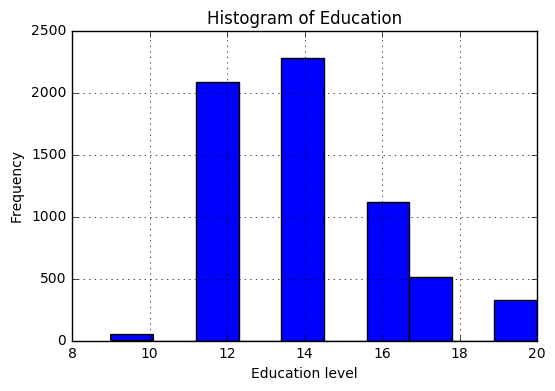

In [44]:
# histogram of education
dta.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education level')
plt.ylabel('Frequency')

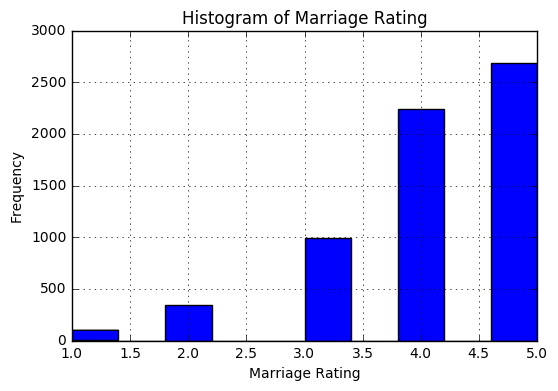

In [45]:
# histogram of marriage rating
dta.rate_marriage.hist()
plt.title('Histogram of Marriage Rating')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Let's take a look at the distribution of marriage ratings for those having affairs versus those not having affairs.

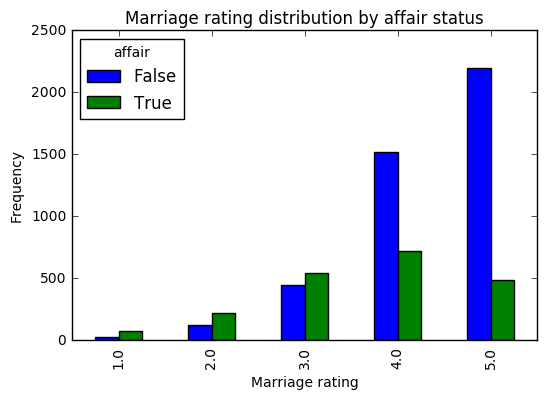

In [46]:
# barplot of marriage rating grouped by affair (True or False)
pd.crosstab(dta.rate_marriage, dta.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage rating distribution by affair status')
plt.xlabel('Marriage rating')
plt.ylabel('Frequency')

Let's use a stacked barplot to look at the percentage of women having affairs by number of years of marriage.

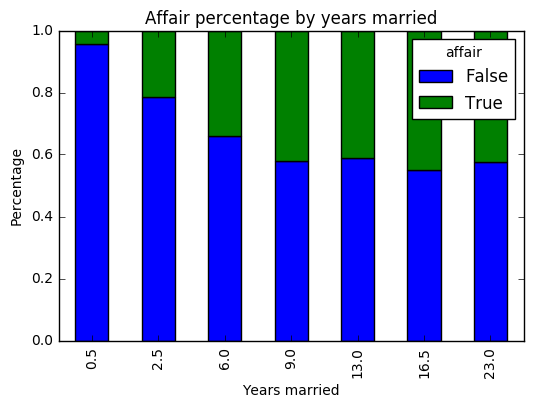

In [47]:
affair_yrs_married = pd.crosstab(dta.yrs_married, dta.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair percentage by years married')
plt.xlabel('Years married')
plt.ylabel('Percentage')

#### Prepare Data for Logistic Regression

To prepare the data, we want to add an intercept column as well as dummy variables for __occupation__ and __occupation_husb__, since we are treating them as categorical variables. The _dmatrices_ function from the _patsy module_ can do that using formula language.

In [48]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb

y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + religious + educ + C(occupation) + C(occupation_husb)', dta, return_type="dataframe")
print(X.columns)

Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')


In [49]:
# renaming column names of X
X = X.rename(columns={'C(occupation)[T.2.0]':'occ_2','C(occupation)[T.3.0]':'occ_3','C(occupation)[T.4.0]':'occ_4','C(occupation)[T.5.0]':'occ_5','C(occupation)[T.6.0]':'occ_6','C(occupation_husb)[T.2.0]':'occ_husb_2','C(occupation_husb)[T.3.0]':'occ_husb_3','C(occupation_husb)[T.4.0]':'occ_husb_4','C(occupation_husb)[T.5.0]':'occ_husb_5','C(occupation_husb)[T.6.0]':'occ_husb_6'})
print(X.columns)

Index(['Intercept', 'occ_2', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_husb_2',
       'occ_husb_3', 'occ_husb_4', 'occ_husb_5', 'occ_husb_6', 'rate_marriage',
       'age', 'yrs_married', 'children', 'religious', 'educ'],
      dtype='object')


We also need to flatten __y__ into a 1-D array, such that scikit-learn will properly understand it as the response variable.

In [50]:
# flatten y into a 1-D array
y = np.ravel(y)
print(y)

[ 1.  1.  1. ...,  0.  0.  0.]


#### Logistic Regression

Let's go ahead and run logistic regression on the entire dataset. 

In [51]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X,y)

# check the accuracy on the training set
model.score(X,y)


0.72588752748978946

73% accuracy seems good, but what's the null error rate?

In [52]:
# what percentage had affairs?
y.mean()

0.32249450204209867

Only 32% of the women had affairs, which means that you could obtain 68% accuracy by always predicting "No". So we're doing better than the null error rate, but not by much.

Let's examine the coefficients to see what we learn.

In [53]:
# examine the coefficients

pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))

,0,1
0,Intercept,[1.48983619804]
1,occ_2,[0.188066300479]
2,occ_3,[0.498947895177]
3,occ_4,[0.250668256923]
4,occ_5,[0.839007913844]
5,occ_6,[0.833908383109]
6,occ_husb_2,[0.190635680061]
7,occ_husb_3,[0.297832410578]
8,occ_husb_4,[0.161408588152]
9,occ_husb_5,[0.187770605337]


Increase in _marriage rating_ and _religiousness_ correspond to a decrease in the likelihood of having an affair. For both the wife's occupation and husband's occupation, the lowest likelihood of having an affair corresponds to the baseline occupation (student), since all of the dummy coefficients are positive. 

#### Model evaluation using a validation set

So far, we have trained and tested on the same data set. Let's split the data set into a training set and a test set.

In [54]:
# evaluate a model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We now need to predict class labels for the test set. We will also generate the class probabilities, just to take a look.

In [55]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print(predicted)

[ 1.  0.  0. ...,  0.  0.  0.]


In [56]:
# generate class probabilities
prob = model2.predict_proba(X_test)
print(prob)

[[ 0.35146325  0.64853675]
 [ 0.90955083  0.09044917]
 [ 0.72567332  0.27432668]
 ..., 
 [ 0.55727381  0.44272619]
 [ 0.8120705   0.1879295 ]
 [ 0.74734599  0.25265401]]


As you can see, the classifier is predicting 1 (having affair) anytime the probability in the second column is greater than 0.5.

Let's generate some evaluation metrics.

In [57]:
# generate evaluation metrics
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, prob[:, 1]))

0.729842931937
0.745950606951


The accuracy is 73%, which is the same as we experienced when training and predicting on the same data.

We can also see the _confusion matrix_ and a _classification report_ with other metrics

In [58]:
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

[[1169  134]
 [ 382  225]]
             precision    recall  f1-score   support

        0.0       0.75      0.90      0.82      1303
        1.0       0.63      0.37      0.47       607

avg / total       0.71      0.73      0.71      1910



#### Model evaluation using Cross-Validation

Now let's try 10-fold cross-validation, to see if the accuracy holds up more rigorously. 

In [59]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[ 0.72100313  0.70219436  0.73824451  0.70597484  0.70597484  0.72955975
  0.7327044   0.70440252  0.75157233  0.75      ]
0.724163068551


After 10-fold cross-validation, we can confirm that model is still performing at 73% accuracy.

#### Predicting the probability of an affair

Let's use above model to predict the probability of an affair for a random woman not present in the dataset. 

New example: age 25 years, occupation is teacher who graduated college, has been married for 3 years, has 1 child, rates herself as strongly religious, rates her marriage as fair, and her husband is a farmer. 

In [63]:
new_ex = [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 25, 3, 1, 4, 16]
model.predict_proba(np.array(new_ex).reshape(1, -1))


array([[ 0.77472246,  0.22527754]])

The predicted probability of an affair is 23%.